In [ ]:
!git clone https://github.com/anm-ol/DreamLab
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p DreamLab/data/video
!mkdir -p DreamLab/data/mario
!mkdir -p DreamLab/weights
!cp drive/MyDrive/data/videos/mario_gameplay.mp4 DreamLab/data/video/mario_gameplay.mp4
%cd DreamLab

In [93]:
from src.data import *
extract_frames('data/video/mario_gameplay.mp4', 400, 1400, 2, 'data/mario', size=(256, 256))
split_data2('data/mario', test_split=0.2, num_frames=1)

Total frames in video: 69878


In [1]:
from src.data import videoDataset
from torch.utils.data import DataLoader
dataset = videoDataset('data/mario', 'data/train.txt', (256, 256))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

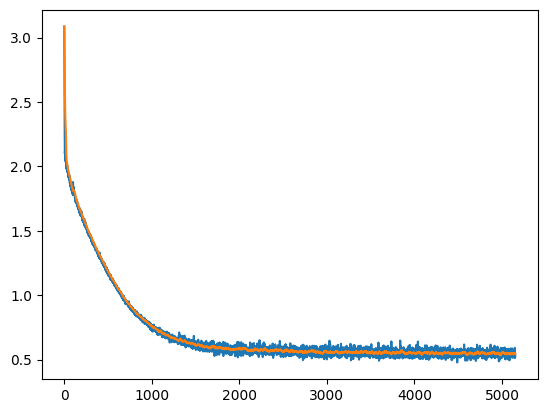

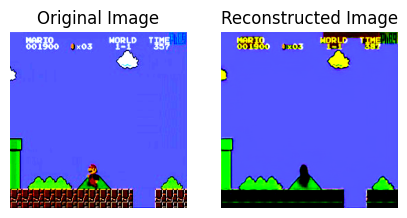

In [4]:
from src.autoencoder import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myvae = vae().to(device)
train(myvae, dataloader, dataset=dataset, lr=0.001, num_epochs=50)


In [4]:
autoencoder = myvae
dataset2 = dataset

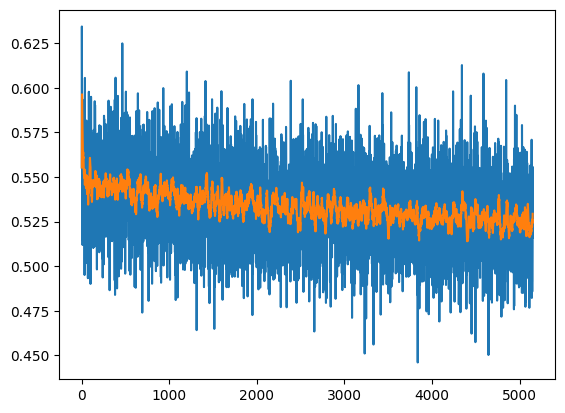

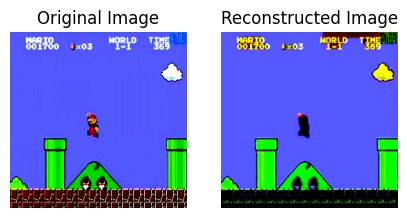

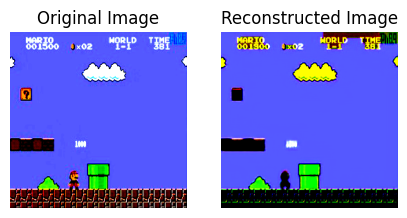

In [5]:
train(myvae, dataloader, lr=0.001, dataset=dataset, num_epochs=50)
sample_image(myvae, dataset, 0)

In [3]:
torch.save(myvae.state_dict(), 'weights/simplevae_weights.pth')
torch.save(dataset, 'weights/dataset.pth')


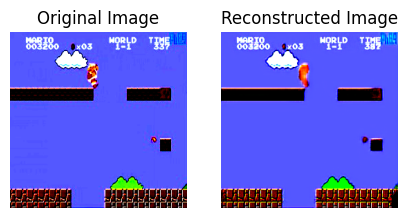

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from src.autoencoder import *
myvae = vae().to(device)
myvae.load_state_dict(torch.load('weights/simplevae_weights.pth'))
dataset = torch.load('weights/dataset.pth')
sample_image(myvae, dataset, 0)

In [48]:
positional_encoding2(torch.arange(0,4), 2)

tensor([[ 0.0000,  1.0000],
        [ 0.8415,  0.5403],
        [ 0.9093, -0.4161],
        [ 0.1411, -0.9900]])

In [15]:
import torch
import torch.nn as nn
import time
import numpy as np
from IPython.display import clear_output
from src.noise_scheduler import get_schedule, add_noise
from src.linear_noise_scheduler import LinearNoiseScheduler

def positional_encoding(ts, dim, period=10000):
    # Ensure ts is a tensor, and reshape for broadcasting
    ts = ts.unsqueeze(1) if ts.dim() == 1 else ts  # Shape: (batch_size, 1)

    # Create a range of positions
    position = torch.arange(0, dim, 2, dtype=torch.float32, device=ts.device)

    # Compute scaling factor
    scale = period ** (position / dim)
    
    # Compute sine and cosine embeddings
    sin_emb = torch.sin(ts / scale)
    cos_emb = torch.cos(ts / scale)

    # Concatenate them along the last dimension to form positional encoding
    emb = torch.stack((sin_emb, cos_emb), dim=-1).view(-1, dim)
    
    return emb

class patchify(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    def forward(self, x): #input shape: (B, C, W, H)
        batch_size, n_channels, self.width, self.height = x.size()
        self.C = n_channels
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        # shape (B, C, W//P, H//P, P, P)
        patches = patches.contiguous().view(batch_size, n_channels, -1, self.patch_size, self.patch_size).permute(0, 2, 1, 3, 4)
        # shape (B, N, C, P, P)
        patches = patches.contiguous().view(batch_size, -1, n_channels * self.patch_size * self.patch_size)
        # shape (B, N, C*P*P)
        return patches

    def unpatchify(self, x): #input shape: (B, N, C*P*P)
        batch_size, num_patches, flattened_dim = x.size()
        patch_size = self.patch_size
        num_channels = self.C
        # Calculate grid dimensions
        grid_size = int(num_patches ** 0.5)
        # Reshape and permute
        x = x.view(batch_size, grid_size, grid_size, num_channels, patch_size, patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        # Combine patches
        x = x.view(batch_size, num_channels, grid_size * patch_size, grid_size * patch_size)
        return x
    
class DiT(nn.Module):
    def __init__(self, dims=512):
        super(DiT, self).__init__()
        input_size = 128
        self.patchify = patchify(2)
        self.embd = nn.Linear(input_size, dims)
        self.fc1 = nn.Linear(dims, dims)
        self.fc2 = nn.Linear(dims, dims)
        self.silu = nn.SiLU()
        self.dims = dims
        self.norm = nn.LayerNorm(dims)
        self.blocks = nn.ModuleList([DIT_block(dims) for _ in range(6)])
        self.linear = nn.Linear(dims, input_size * 2)
        self.time_emb_layer = nn.Sequential(
            nn.Linear(dims, dims),
            nn.SiLU(),
            nn.Linear(dims, dims),
        )
    def forward(self, x, t): #input shape: (B, N, C, W, H)
        x = self.patchify(x)
        x = self.embd(x) 
        x = self.fc1(x)
        x = self.silu(x)
        x = self.fc2(x)
        # X shape: B, N, D
        spatial_embedding = positional_encoding(torch.arange(x.shape[1]), self.dims)
        spatial_embedding = spatial_embedding.repeat(x.size(0), 1, 1).to(device) # shape: B, N, D
        x = x + spatial_embedding # shape: B, N, D
        noise_embedding = positional_encoding(t, self.dims).unsqueeze(1).to(device) #shape: B, 1, D
        noise_embedding = self.time_emb_layer(noise_embedding)
        x = torch.concat((x, noise_embedding), dim=1)
        for block in self.blocks:
            x = block(x)
        x = self.linear(x)
        x = x[:, :-1, :]
        x = x.contiguous()
        noise, var = torch.chunk(x, 2, dim=2)
        noise, var = self.patchify.unpatchify(noise), self.patchify.unpatchify(var)
        var = 0 * var #removing variance for now
        noise = (noise + torch.randn(var.size()).to(device) * var)
        return noise
    
class DIT_block(nn.Module):
    def __init__(self, dims):
        super(DIT_block, self).__init__()
        self.norm1 = nn.LayerNorm(dims)
        self.norm2 = nn.LayerNorm(dims)
        self.attn = nn.MultiheadAttention(dims, num_heads=4, batch_first=True)
        self.linear = nn.Linear(dims, dims)

    def forward(self, x):
        residue = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x += residue
        residue = x
        x = self.norm2(x)
        x = self.linear(x)
        x += residue
        return x

def train_denoiser(dit_model, vae, dataloader, num_steps=10, lr=0.0001, num_epochs=10, scheduler='cosine'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dit_model.train()
    vae.eval()
    if scheduler == 'linear':
        linear = LinearNoiseScheduler(num_steps, beta_start=0.0001, beta_end=0.02)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(dit_model.parameters(), lr=lr)
    alphas = get_schedule(num_steps)
    losses = []
    losses_mean = []
    for epoch in range(num_epochs + 1):
        for i, input in enumerate(dataloader):
            input = input[:, 0].to(device)
            with torch.no_grad():
                input = vae.encoder(input)
                input = (input - 2) / 3.5
                batch_Size = input.shape[0]
                original_noise = torch.randn_like(input).to(device)
                if scheduler == 'cosine':
                    t = torch.randint(0, num_steps-1, size=(batch_Size,))
                    alpha = torch.tensor(alphas[t])
                    alpha = alpha.reshape(-1, 1, 1, 1).to(device)
                    noised, original_noise = add_noise(input, alpha)
                    noised = noised.float().to(device)
                    original_noise = original_noise.to(device)
                elif scheduler == 'linear':
                    t = torch.randint(0, num_steps - 1, (batch_Size,))
                    noised = linear.add_noise(input, original_noise, t)
            optimizer.zero_grad()
            loss = criterion(dit_model(noised, t), original_noise)
            losses.append(loss.item())
            loss_mean = torch.tensor(losses[-40:]).mean()
            losses_mean.append(loss_mean)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss_mean:.4f}')
        if epoch % 5 == 0:
            clear_output()
            plt.plot(losses)
            plt.plot(losses_mean)
            plt.show()

def diffusion_sampler(vae, dit_model, num_steps=10, scheduler='cosine'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.eval()
    dit_model.eval()
    img = dataset[0][0].unsqueeze(0).to(device)
    latent = vae.encoder(img)
    latent = torch.randn(latent.size()).to(device)
    output = vae.decoder(latent)
    if scheduler=='cosine':
        alphas_cum = torch.tensor(get_schedule(num_steps))
    elif scheduler=='linear':
        linear = LinearNoiseScheduler(num_steps, beta_start=0.0001, beta_end=0.02)
    plt.figure(figsize=(3, 3))
    plt.imshow(output[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    with torch.no_grad():
        for t in torch.arange(num_steps-1, -1, -1):
            eps =  dit_model(latent, t)
            if scheduler == 'cosine':
                alpha_t = alphas_cum[t]/alphas_cum[t-1] if t > 0 else alphas_cum[t]
                print(f'Step {t}, alpha: {alphas_cum[t]}')
                sigma_t = (1 - alpha_t) * (1 - alphas_cum[t-1]) / (1 - alphas_cum[t])
                sigma_t = sigma_t ** 0.5
                # denoise from z_t to z_0 but also add some noise to get z_(t-1)  [i think thats how it works] 
                latent = (latent - (eps * (1 - alpha_t)/torch.sqrt(1 - alphas_cum[t]))) / torch.sqrt(alpha_t) 
            elif scheduler == 'linear':
                sigma_t = 0
                latent, _ = linear.sample_prev_timestep(latent, eps, t)
                            
            if t == 0:
                latent = latent
            else:   
                z = torch.randn_like(latent).to(device) 
                latent = latent + sigma_t * z
            output = vae.decoder(latent * 3.5 + 2)
            output = torch.clamp(output, 0, 1)
            if t % (num_steps//10) == 0:
                print(f'Step {t}')
                plt.figure(figsize=(3, 3))
                plt.imshow(output[0].permute(1, 2, 0).cpu().numpy())
                plt.axis('off')
                plt.show()

In [5]:
dit = DiT().to(device)

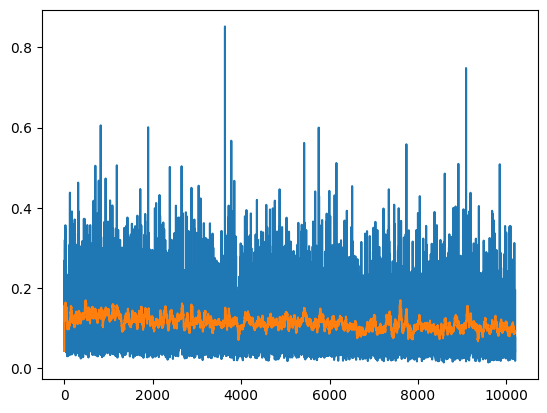

In [17]:
train_denoiser(dit, myvae, dataloader, num_steps=1000, lr=1e-4, num_epochs=100, scheduler='linear')


In [19]:
torch.save(dit.state_dict(), 'weights/dit_weights_step1000patch2linear.pth')

In [6]:
dit.load_state_dict(torch.load('weights/dit_weights_step100.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0133150825..2.418837].


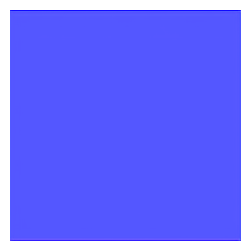

Step 900


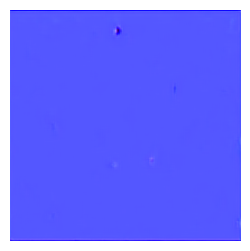

Step 800


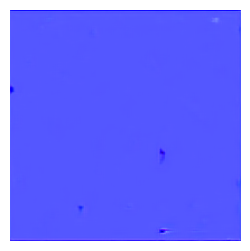

Step 700


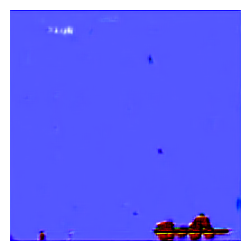

Step 600


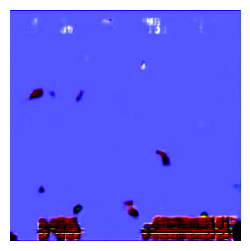

Step 500


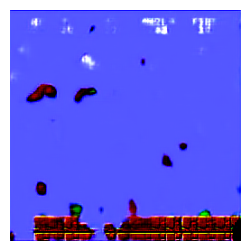

Step 400


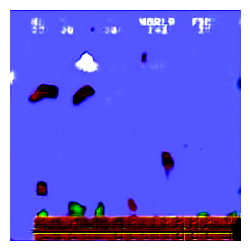

Step 300


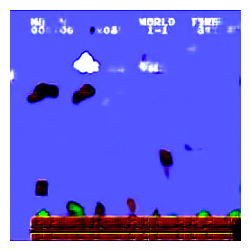

Step 200


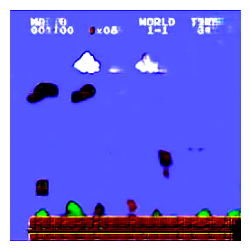

Step 100


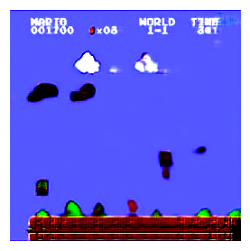

Step 0


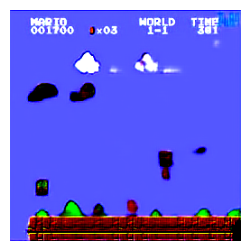

In [18]:
diffusion_sampler(myvae, dit, num_steps=1000, scheduler='linear')